# Poverty Analysis in NL - workshop

## Settting up

### Load data

In [ ]:
%%capture
!wget -O "nos_data.csv.zip" "https://www.dropbox.com/scl/fi/5b0kkjih4xv9rnsfzbw63/nos_data_final_pruned.csv.zip?rlkey=ytgbvwj3238dnjd33wg7yu50y&dl=1"
!wget -O "ipsos_polls.csv" "https://www.dropbox.com/scl/fi/gzsr1ocq63xez3n79x048/ipsos_polls.csv?rlkey=0hf2xqrdt6c8spw7czwi89mt9&dl=1"
!wget -O "full_model_en.zip" "https://www.dropbox.com/scl/fi/1z4rhdupham561bar3ngx/full_model_en.zip?rlkey=k3c975ol1le94tunnevvlrzs5&dl=1"
!unzip -o nos_data.csv.zip
!unzip -o full_model_en.zip
!wget -O "cbs_consumer_trust.csv" "https://www.dropbox.com/scl/fi/tre8belg4w6ujt81cimvq/cbs_consumer_trust.csv?rlkey=y4qugewaegpq0wfffz456ga8i&dl=1"


### Install dependencies

In [3]:
!pip3 install bertopic --no-deps
!pip3 install pandas scikit-learn hdbscan umap-learn
!pip3 install sentence-transformers --no-deps
!pip3 install geopandas
!pip3 install geoplot
!pip3 install wordcloud
!pip3 install plotly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.1/154.1 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 8.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 10.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached Cython-0.29.37-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 6.7 MB/s eta 0:00:00
  Created wheel for hdbscan: filename=hdbscan-0.8.33-cp310-cp310-linux_x86_64.whl size=3039286 sha256=e9a1968c8d04afe0d895032b9f439d2a8fd3937982eb152f4e19ec12c5fa8b81
  Stored in directory: /root/.cache/pip/wheels/75/0b/3b/dc4f60b7cc455efaefb62883a7483e76f09d06ca81cf87d610
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86832 sha256=26d18223481507ab

### Imports and helper functions

In [ ]:
# import libraries
import pandas as pd
import bertopic as bt
from bertopic.representation import TextGeneration
from transformers import pipeline
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import geoplot as gplt
import plotly.io as pio
from wordcloud import WordCloud
import re

import random
from umap import UMAP
from hdbscan import HDBSCAN

import scipy.sparse as sp

from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer

# set seed for reproducibility
SEED = 42
random.seed(SEED)
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0,
                  metric='cosine', random_state=SEED)
hdbscan_model = HDBSCAN(min_cluster_size=150, metric='euclidean',
                        cluster_selection_method='eom', prediction_data=True)

# TF-IDF Transformer helper class
class CTFIDFVectorizer(TfidfTransformer):
    def __init__(self, *args, **kwargs):
        super(CTFIDFVectorizer, self).__init__(*args, **kwargs)

    def fit(self, X: sp.csr_matrix, n_samples: int):
        """Learn the idf vector (global term weights) """
        _, n_features = X.shape
        df = np.squeeze(np.asarray(X.sum(axis=0)))
        idf = np.log(n_samples / df)
        self._idf_diag = sp.diags(idf, offsets=0,
                                  shape=(n_features, n_features),
                                  format='csr',
                                  dtype=np.float64)
        return self

    def transform(self, X: sp.csr_matrix) -> sp.csr_matrix:
        """Transform a count-based matrix to c-TF-IDF """
        X = X * self._idf_diag
        X = normalize(X, axis=1, norm='l1', copy=False)
        return X

# normalize helper function
def normalize_series(series):
    return (series - series.mean()) / series.std()


## Exercise 0: Loading the data and doing some exploration

### Loading in the dataset

This dataset has over a 150,000 news articles (rows), the followings columns are present:

* `datetime`: time of posting
* `title`: title of article
* `category`: category of the news
* `url`: URL of the article
* `embedding`: OpenAI LLM embeddings of the article (not used in the notebook, but can be used later)
* `location`, `lat`, `long`, `province`: location estimates of each article, obtained by Named Entity Recongition + Google Maps API
* `translated_content`: content of the article, translated to English using Google Translate
* `secret_cluster`: categorization of articles about poverty

In [ ]:
df = pd.read_csv('nos_data_final_pruned.csv', parse_dates=['datetime'])

# cast embeddings to numpy array
df['embedding'] = df['embedding'].apply(
    lambda x: np.fromstring(x[1:-1], sep=',', dtype=np.float16))
# sort by datetime
df = df.sort_values(by='datetime')

<ipython-input-10-f7eee6ed2a00>:5: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.
  lambda x: np.fromstring(x[1:-1], sep=',', dtype=np.float16))


In [ ]:
# show first 5 rows of data frame to see what's in the data
df.head()

,datetime,title,category,url,embedding,location,lat,lng,province,translated_content,secret_cluster
0,2010-01-01 05:14:00,"Museumplein vol, minder druk in Rotterdam",Binnenland,https://nos.nl/artikel/126232-museumplein-vol-...,[0.015],museumplein,52.357256,4.882328,Noord-Holland,The New Year's Eve party on Museumplein in Ams...,NaN
1,2010-01-01 09:55:00,"Zeeuw wint 27,5 miljoen in Staatsloterij",Binnenland,https://nos.nl/artikel/126247-zeeuw-wint-27-5-...,[-0.026],noord-brabant,51.482654,5.232169,North Brabant,The main prize of the New Year's Eve draw of t...,NaN
2,2010-01-01 11:45:00,Recordaantal sms'jes verstuurd,Binnenland,https://nos.nl/artikel/126269-recordaantal-sms...,[0.017],NaN,NaN,NaN,NaN,A record number of text messages were sent las...,NaN
3,2010-01-01 12:41:00,Ik Hou van Holland het populairst,Binnenland,https://nos.nl/artikel/126279-ik-hou-van-holla...,[-0.013],NaN,NaN,NaN,NaN,The TV program 'I love Holland' was the most w...,NaN
4,2010-01-01 12:46:00,Nog veel oogletsel door vuurwerk,Binnenland,https://nos.nl/artikel/126275-nog-veel-ooglets...,[-0.002],nieuw-vennep,52.264028,4.631801,North Holland,22 fireworks victims were admitted to the Eye ...,NaN


### Creating visualizations

Let's create some basic visualizations about 3 aspects of the data:

* The distribution of categories in the data
* The distribution of articles over time
* The spatial distribution of articles

Are there results in line with your expectation? Why/Why not?

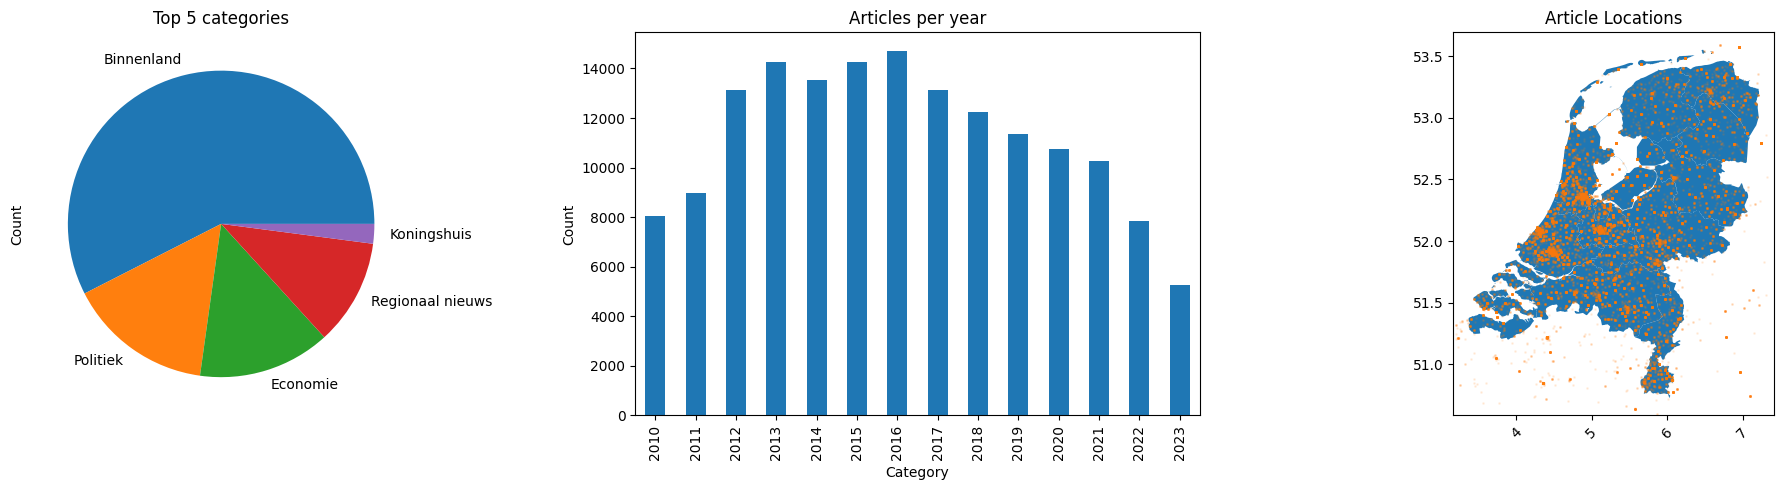

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(20, 5))

# Create pie plot of the categories to see the division of different categories in the data
df['category'].value_counts().iloc[:5].plot(
    kind='pie', title='Top 5 categories', xlabel='Category', ylabel='Count', ax=ax[0])

# bar plot to show the number of articles per year
df['datetime'].dt.year.value_counts().sort_index().plot(kind='bar', title='Articles per year', xlabel='Category', ylabel='Count', ax=ax[1]);
# rotate x-axis labels for readability
plt.xticks(rotation=45)

plt.tight_layout()
# Geoplot to gain insights about locations that are more often in the news, we take a
# map of the netherlands from stack.stanford.edu and plot the locations of the articles
gdf = gpd.read_file('https://stacks.stanford.edu/file/druid:st293bj4601/data.zip')
gdf = gdf[gdf['TYPE_1'] == 'Provincie']
# drop all rows where ENGTYPE_1 is not 'Province'
gdf.plot(ax=ax[2])
xlims = ax[2].get_xlim()
ylims = ax[2].get_ylim()
ax[2].scatter(df['lng'], df['lat'], color='tab:orange', alpha=0.1, s=1)
ax[2].set_xlim(*xlims)
ax[2].set_ylim(*ylims)
ax[2].set_title('Article Locations');

## Exercise 1: TF-IDF exploration

We will be applying TF-IDF on a subset of our dataset, namely, on articles directly related to poverty. The goal is to find topics (words) in the articles about poverty that are special (very important) in that certain year. Those words are commonly that year, but less common in the others.

We follow the following plan:

1. Create a slice of the data that contains only poverty articles (we have classified this data already for you). We save this slice in a temporary data frame called `poverty_df`.

2. We then divide our dataset into a separate cluster, each cluster representing articles from one calendar year. The first cluster, 2010, will be cluster 0, 2011 will be cluster 1, and so forth.

3. We then fit the data on a `CountVectorizer`, a class from `sklearn`. This class performs Bag of Words, e.g., it turns our text into vectors that contain the frequency of all unique words.

4. We then perform TF-IDF on each cluster, compared to all articles about poverty.

5. We visualize the results in a word cloud for the year 2022.

It can be initialized as follows:

`count_vectorizer = CountVectorizer(stop_words="english")`

Where stop_words is set to English, so that the bag of words method skips stop words used in the English language.



In [ ]:
# create the poverty dataframe, ignoring NaN values in the secret_cluster column
poverty_df = df.dropna(subset=['secret_cluster']).copy()
# select all rows where the secret_cluster is 1, where 1 indicates articles related to poverty
poverty_df = poverty_df[poverty_df['secret_cluster'] == 1]
# get the year for each article, save it in a new column called 'year'
poverty_df['year'] = poverty_df['datetime'].dt.year
# Group by year
poverty_df = poverty_df[['translated_content', 'year']]
# show the dataframe
poverty_df.head()

,translated_content,year
131,Prime Minister Balkenende thinks it is a good ...,2010
141,More and more small self-employed people are e...,2010
363,The FNV continues to heavily criticize the gov...,2010
669,"By literary editor Jef van Gool ""Do you ever h...",2010
689,"In some cities, student actions will continue ...",2010


Now, we group all documents of each year together. This makes each year one big 'article', such that we can easily count the word occurance for each year.

The output you get should look like this:

|    |   year | translated_content           |
|---:|-------:|:-----------------------------|
|  0 |   2010 | Prime Minister Balkenende... |
|  1 |   2011 | By editor Sander Warmerda... |
|  2 |   2012 | One in five Greeks lives ... |
|  3 |   2013 | Hundreds of church buildi... |
| ... | ... | ... |

In [ ]:
# group by year and concatenate all articles in that year
articles_per_year = poverty_df.groupby(['year'], as_index=False).agg({'translated_content': ' '.join})
# show the dataframe (first 5 rows)
articles_per_year.head()

,year,translated_content
0,2010,Prime Minister Balkenende thinks it is a good ...
1,2011,"By editor Sander Warmerdam ""What is happening ..."
2,2012,One in five Greeks lives below the poverty lin...
3,2013,Hundreds of church buildings are at risk of be...
4,2014,The national population screening for colon ca...


Now, we perform Bag of Words using sklearns CountVectorizer. We ignore English stop words, in the end, we obtain:

* `count`: An array with counts for each unique word and all the articles per year. The array has shape `(N_years, N_unique_words)`
* `word`: An array with all unique words. This array has a shape `(N_unique_words)`, there are over 17,000 unique words found!

In the end, we print an examle of 10 identified words:

`array(['judges', 'judgment', 'judgments', 'judicial', 'judiciary',
       'judikje', 'judith', 'juffermans', 'juice', 'juliana'],
      dtype=object)`

Can you spot a weakness of Bag of Words based on this output?



In [ ]:
# create a bag of words class using CountVectorizer
count_vectorizer = CountVectorizer(stop_words="english")
# get the counts of each word in the corpus, for each class
count = count_vectorizer.fit_transform(articles_per_year.translated_content)
# get the unique words in the corpus
words = count_vectorizer.get_feature_names_out()

# example of the first 10 words
words[len(words)//2: len(words)//2 + 10]

array(['judges', 'judgment', 'judgments', 'judicial', 'judiciary',
       'judikje', 'judith', 'juffermans', 'juice', 'juliana'],
      dtype=object)

Now we perform TF-IDF, this class calculates the TF-IDF values for each article cluster, for each term, as such, it has the same shape as `count`.

This results in an array with a score for every year and every unique word.

In [ ]:
# Create a TF-IDF class, using the helper class defined in the beginning of this notebook
ctfidf = CTFIDFVectorizer().fit_transform(count, n_samples=len(poverty_df)).toarray()

ctfidf

array([[0.00000000e+00, 1.09909983e-04, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 6.54719942e-04, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 5.18205838e-04, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 6.29544964e-04, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [9.82221736e-05, 4.40180993e-04, 6.68210854e-05, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 6.03135212e-04, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

We select a year using `selected_year`. You can choose any year in the range 2010-2023

In [ ]:
# Select a year. Note you can change the year as long as its in the range 2010-2023
selected_year =  2022

Show the top 25 terms and their TF-IDF values. Do you think it makes sense?

In [ ]:
# get values for the selected year, the index starts at 2010
ctfidf_values = ctfidf[selected_year - 2010]
# get the indices of the top 25 words
top_25_indices = ctfidf_values.argsort()[-25:][::-1]
# get the 25 words with the highest TF-IDF values
top_25_words = {words[index]: ctfidf_values[index] for index in top_25_indices}
# get the tfidf values for the top 25 words
top_25_values = [ctfidf_values[index] for index in top_25_indices]
# create a dataframe with the top 25 words and their tfidf values
top_25_df = pd.DataFrame({'word': list(top_25_words.keys()), 'tfidf': list(top_25_words.values())})

top_25_df

,word,tfidf
0,inflation,0.002634
1,prices,0.002236
2,price,0.002152
3,ceiling,0.001867
4,purchasing,0.001798
5,gas,0.001690
6,power,0.001608
7,energy,0.001583
8,compensation,0.001546
9,households,0.001486


Now, let's make a word cloud of the terms!

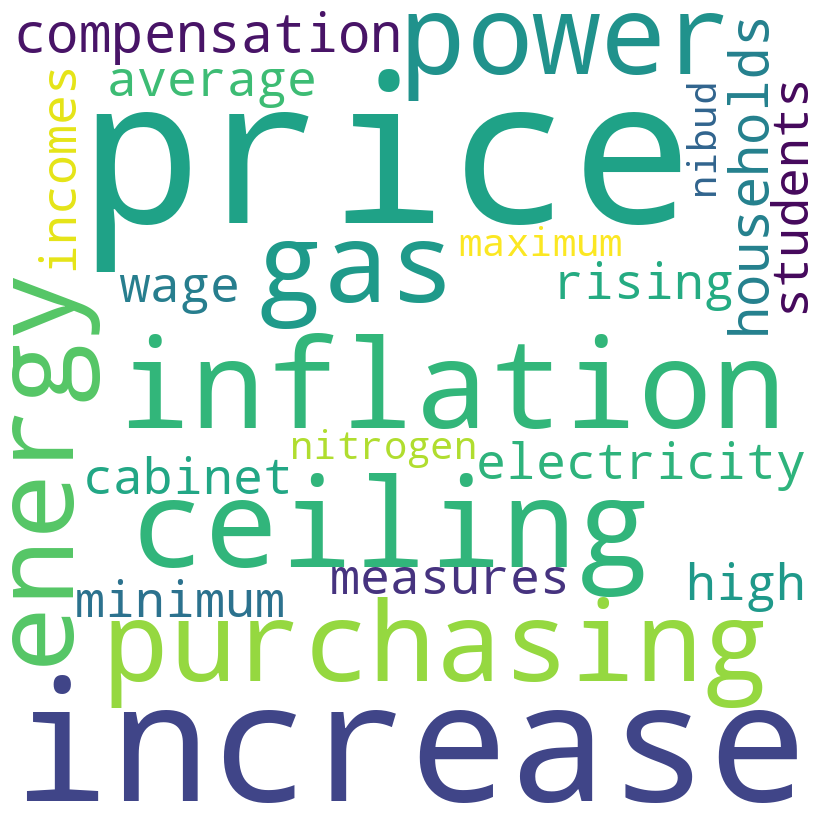

In [ ]:
# Convert the list of keywords into a single string with spaces
text = " ".join(top_25_df['word'])

# Create a WordCloud object
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(text)

# Display the generated image:
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

## Exercise 2: BERTopic

In this exercise we will visualize the embedding space used by BERTopic. We created the embeddings already.

1. We will use BERTopic to visualize the embeddings in a UMAP, clustering similar topics. Note, the code is commented out, because it takes a long time to fit the model. However, you can run this code later.
2. Next we will look at the topics identified and what is in their representation.
3. You can visualize the embedding space. As this takes a long time we will provide the HTML, so we can check it out. Later you can run this part of the code as well.  


The results of the visualisation can be seen by clicking on this [link](https://www.dropbox.com/scl/fi/v3pvl10q6axzwyyv4jnt1/visualize_documents_top25.html?rlkey=kf9o4sgrhlogsz2caw7ki8fft&dl=1)

This is how you would fit the (clustering) model, depending on your CPU/GPU setup.
For now, we'll skip this part and load the fitted model in.

In [ ]:
""" Fit the BERTopic model """
# documents = df['translated_content'].tolist()
# embeddings = np.array(df['embedding'].tolist())

# vectorizer_model = CountVectorizer(stop_words="english")
# bertopic_model = bt.BERTopic(umap_model=umap_model, hdbscan_model=hdbscan_model, verbose=True, vectorizer_model=vectorizer_model)


Look at the topics and their representations.

Note: `-1` is a remainder topic, all articles that couldn't be fitted are stored here. For this reason we will ignore `Topic` `-1`

In [ ]:
bertopic_model = bt.BERTopic.load("full_model_en")
df['topic'] = bertopic_model.topics_
bertopic_model.get_topic_info().head(25).iloc[:, :-1]

2024-03-21 08:10:35,163 - BERTopic - WARNING: You are loading a BERTopic model without explicitly defining an embedding model.If you want to also load in an embedding model, make sure to useBERTopic.load(my_model, embedding_model=my_embedding_model).


,Topic,Count,Name,Representation
0,-1,51047,-1_says_according_people_police,"[says, according, people, police, van, party, ..."
1,0,9839,0_patients_care_healthcare_hospital,"[patients, care, healthcare, hospital, corona,..."
2,1,6036,1_film_program_prize_music,"[film, program, prize, music, book, radio, ser..."
3,2,3571,2_accident_car_driver_road,"[accident, car, driver, road, truck, man, inju..."
4,3,2985,3_ns_train_trains_prorail,"[ns, train, trains, prorail, transport, travel..."
5,4,2935,4_students_education_school_schools,"[students, education, school, schools, teacher..."
6,5,2915,5_asylum_seekers_refugees_reception,"[asylum, seekers, refugees, reception, shelter..."
7,6,2914,6_schiphol_klm_airport_flights,"[schiphol, klm, airport, flights, aircraft, ai..."
8,7,2819,7_man_police_shooting_arrested,"[man, police, shooting, arrested, shot, injure..."
9,8,2677,8_brigade_smoke_building_residents,"[brigade, smoke, building, residents, broke, e..."


In [1]:
bertopic_model.get_topic_info().head(25).iloc[:, :-1]["Name"]

NameError: name 'bertopic_model' is not defined

This is how you could generate a latent space visualization, again, we'll skip this for now as it is quite CPU intensive, and provide you the [html](https://www.dropbox.com/scl/fi/v3pvl10q6axzwyyv4jnt1/visualize_documents_top25.html?rlkey=kf9o4sgrhlogsz2caw7ki8fft&dl=1) file directly.
If you have already downloaded the file, no need to click on this link again.

In [ ]:
"""Reduce dimensionality of embeddings, this step is optional but much faster to perform iteratively:"""
# reduced_embeddings = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine', random_state=SEED).fit_transform(embeddings)
# fig = bertopic_model.visualize_documents(documents, reduced_embeddings=reduced_embeddings, topics=list(range(1, 26)))
# pio.write_html(fig, file='visualize_documents.html', auto_open=False)


## Exercise 3: Spatial distribution of topics
In this exercise we investigate how news topics are distributed geographically.
We do this by:
1. Selecting a specific topic. You can select your own by running `bertoptic_model.get_topic_info()` or choose some of the topics we suggest below.
2. Create a plot where news articles are plotted on their approximate locations.


In [ ]:
# Take a selected topic, to see all topics, run bertopic_model.get_topic_info()
# Suggestions:
selected_topic = 1

<GeoAxes: xlabel='None', ylabel='None'>

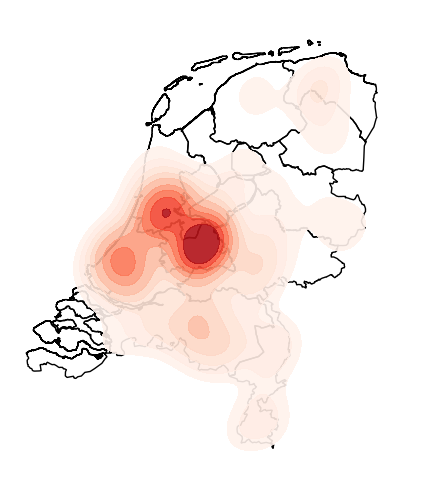

In [ ]:
# take a selected topic, to see all topics, run bertopic_model.get_topic_info()
selected_topic = 1
df_topic = df[df['topic'] == selected_topic].dropna(subset=['lng', 'lat'])

# plot the dutch geodata
# Load shapefiles of NL
gdf = gpd.read_file('https://stacks.stanford.edu/file/druid:st293bj4601/data.zip')

# take a selected topic, to see all topics, run bertopic_model.get_topic_info()
selected_topic = 11
df_topic = df[df['topic'] == selected_topic].dropna(subset=['lng', 'lat'])

# make geo dataframe, has cols lat and lng
gdf_temp = gpd.GeoDataFrame(df_topic, crs="EPSG:4326", geometry=gpd.points_from_xy(df_topic.lng, df_topic.lat, crs="EPSG:4326"))

# limit to articles with geo location in NL
points_within_gdf = gpd.sjoin(gdf_temp, gdf, how='inner', op='within')

# plot
ax = gplt.polyplot(gdf, projection=gplt.crs.AlbersEqualArea(), zorder=1)
gplt.kdeplot(
      points_within_gdf, cmap='Reds', shade=True, ax=ax,
      thresh=0.1,
      alpha=.9
    )

Why do you think a lot of these plots look similar? Do you have an idea of how to fix this?

## Exercise 4: Analysis using topics developments

In this exercise we will 1) explore how the frequencies of news mentions within a topic change over time, and 2) see if we can find correlections with the perception of economics.

To do this, we take the following steps:


1.   Get the topic counts for every month in the years 2010 to 2023. The topics are the topics found using BERTopic clustering (UMAP).
2.   Normalize the counts
3. Select a topic and plot the counts for that topic over time (months in the years 2010 to 20230).
4. Use economic perception data from the CBS and select one indicator to plot it over time.
5. Combine economic perception data and a selected topic from our news data and see if there are any correlations vissible.




First we create a dataframe where for every month in the years 2010 to 2023 the topic mentions are counted.
In other words, we count how many times a topic e.g., `4_students_education_school_schools` is mentioned in a specific month.

In [ ]:
# get calendar months
df['month'] = df['datetime'].dt.to_period('M').dt.to_timestamp()
# group by month and topic and count the number of articles
monthly_topic_counts = df.groupby(['month', 'topic']).size().unstack().fillna(0).iloc[:, 1:]
# set the BERTopic topic names as columns
monthly_topic_counts.columns = bertopic_model.get_topic_info()['Name'].iloc[1:]

# visualize a part of the newly created data frame to see what's in it.
monthly_topic_counts.iloc[:10, :5]

Name,0_patients_care_healthcare_hospital,1_film_program_prize_music,2_accident_car_driver_road,3_ns_train_trains_prorail,4_students_education_school_schools
month,,,,,
2010-01-01,24.0,29.0,9.0,22.0,9.0
2010-02-01,19.0,13.0,6.0,12.0,10.0
2010-03-01,22.0,14.0,6.0,13.0,8.0
2010-04-01,16.0,32.0,4.0,9.0,12.0
2010-05-01,18.0,12.0,4.0,9.0,11.0
2010-06-01,23.0,13.0,7.0,9.0,10.0
2010-07-01,30.0,14.0,8.0,16.0,5.0
2010-08-01,16.0,28.0,16.0,10.0,6.0
2010-09-01,38.0,13.0,10.0,10.0,16.0


Normalize the topic counts.

In [ ]:
# normalize the counts by dividing by the total number of articles in that month
normalized_monthly_topic_counts = monthly_topic_counts.div(monthly_topic_counts.sum(axis=1), axis=0)

# visualize part of the data frame, to see the normalized counts
normalized_monthly_topic_counts.iloc[:10, :5]

Name,0_patients_care_healthcare_hospital,1_film_program_prize_music,2_accident_car_driver_road,3_ns_train_trains_prorail,4_students_education_school_schools
month,,,,,
2010-01-01,0.061069,0.073791,0.022901,0.055980,0.022901
2010-02-01,0.048346,0.033079,0.015267,0.030534,0.025445
2010-03-01,0.056122,0.035714,0.015306,0.033163,0.020408
2010-04-01,0.035794,0.071588,0.008949,0.020134,0.026846
2010-05-01,0.050704,0.033803,0.011268,0.025352,0.030986
2010-06-01,0.063712,0.036011,0.019391,0.024931,0.027701
2010-07-01,0.074442,0.034739,0.019851,0.039702,0.012407
2010-08-01,0.039702,0.069479,0.039702,0.024814,0.014888
2010-09-01,0.096447,0.032995,0.025381,0.025381,0.040609


Choose a topic to plot.
We have made a selection of interesting topics you can choose from:

But, you can also choose any topic yourself as long as it was found by the BERTopic clustering we did before `bertopic_model.get_topic_info()['Name']`.


In [ ]:
# Set your own selected topic to visualize
selected_topic = '0_patients_care_healthcare_hospital'

Plot `selected_topic` over time.

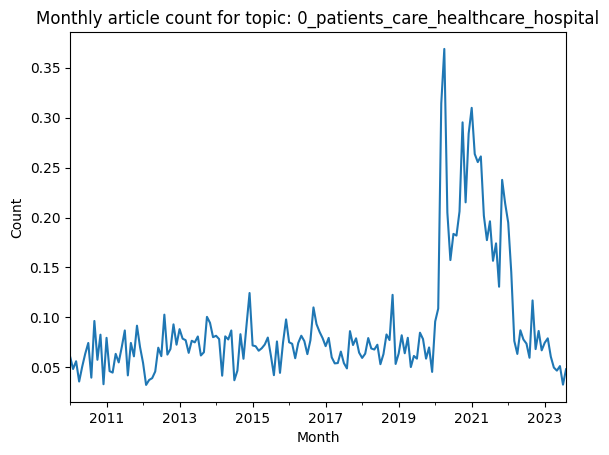

In [ ]:
normalized_monthly_topic_counts[selected_topic].plot(xlabel='Month', ylabel='Count', title='Monthly article count for topic: ' + selected_topic);

Next we will look at the economic perception data from the CBS. We will first load the data into a data frame. Then we will set the index of the data to months and look at the variable `Koopbereidheid` by plotting it.

<Axes: xlabel='month'>

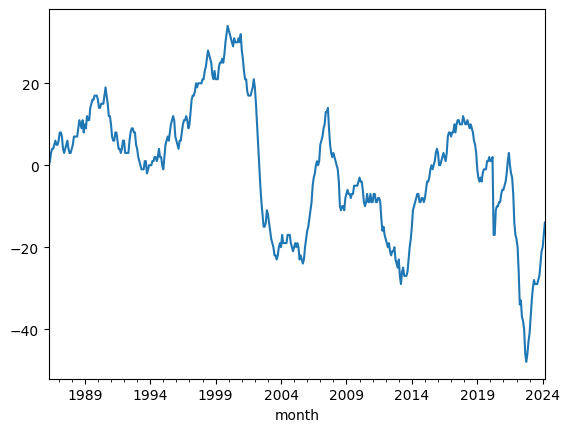

In [ ]:
# load CBS data in data frame
df_cbs = pd.read_csv('cbs_consumer_trust.csv', sep=';')
# set index to month
df_cbs['month'] = pd.to_datetime(df_cbs['Perioden'], format='%YMM%m')
df_cbs.set_index('month', inplace=True)
# plot the Koopbereidheid variable
df_cbs['Koopbereidheid'].plot()

Now we will combine the plots from our news data with the CBS plot, to see if we can (visually) identify any correlations.

As an example we have used the following columns from the data set:
- From the news data we use the topic `16_housing_mortgage_homes_rental`
- From the CBS data we use the feature `EconomischeSituatieKomende12Maanden`

However, you can use any topics and features you want to explore if you can find any other interesting correlations.

In [ ]:
# Select the topic(s) from the news data you want to visualize
selected_topics = ['16_housing_mortgage_homes_rental']

# Select a CBS feature you want to plot
cbs_feature = 'EconomischeSituatieKomende12Maanden'


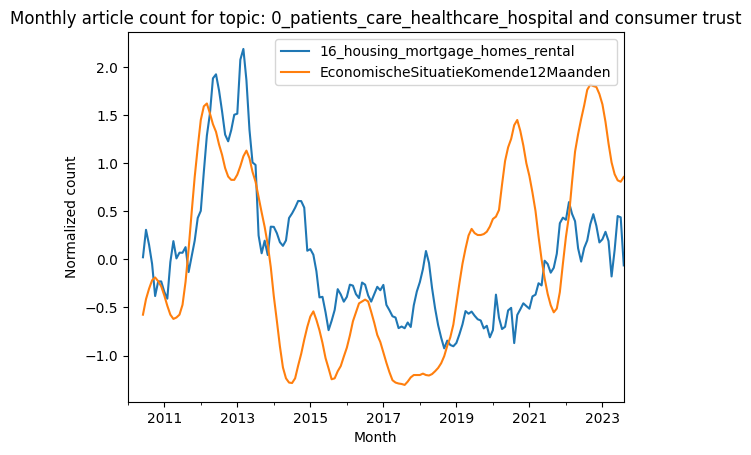

In [ ]:
# create a combined data frame of the selected news topic(s) and the cbs_feature
plot_df = normalized_monthly_topic_counts[selected_topics].join(-df_cbs[cbs_feature])
# apply normalization to the columns
plot_df = plot_df.apply(normalize_series)
# apply 3 month rolling average
plot_df = plot_df.rolling(6).mean()

# plot the data frame
plot_df.plot(xlabel='Month', ylabel='Normalized count', title='Monthly article count for topic: ' + selected_topic + ' and consumer trust');

In [ ]:
# TODO: add some possible interesting things participants can do


## Survey

Please let us know what you think about this workshop by filling in our [survey](https://workshop-march26.kickstartai-events.org/page/1498843).

Thank you!

### Backup

Loading data


In [ ]:
%%capture
# nos_data.csv.zip
!gdown 1NZf16cNgIqKhQvVzqW65Nivds_tWPxuE

# ipsos_polls.csv
!gdown 1qwBMbZvo9R6QDKhiJIyOa8f28h5Hfydu

# full_model_en.zip
!gdown 1Pze19r-k0wvzN6ZemNwCWeYz3A1nRPgG

# cbs_consumer_trust.csv
!gdown 1oqMIHMNNLVjyrOSDwbOXAZw4sVCkgIqZ

!unzip -o nos_data.csv.zip
!unzip -o full_model_en.zip